In [42]:
from message import EmailMessage
import json

def load_messages(env_name):
    with open("./out/" + env_name + ".json", "r") as file_obj:
        jsonobj = json.load(file_obj)
    
    rounds = dict()
    all_messages = []

    for round_index, round in enumerate(jsonobj["rounds"]):
        rounds[round_index] = []

        for index, message in enumerate(round["emails"]):
            message = EmailMessage(
                name = message.get("name", "Unnamed"),
                recipient = message["recipient"],
                sender = message["sender"],
                subject = message.get("subject", "Message " + str(index)),
                #attachments = attachments,
                content = message["content"],
                respond_to = message.get("respond_to", True),
                type = message.get("type", None),
                infected = float(message.get("infected", False)),
                generated = message["generated"],
                original_message = message["original_message"],
                context_messages = message["context_messages"],
            )
            rounds[round_index].append(message)
            all_messages.append(message)

    print(f'Loaded {len(rounds)} rounds with {len(all_messages)} total messages for table "{jsonobj["name"]}"')
    return rounds, all_messages

# Reply Rate by Email Category

In [43]:
rounds, all_messages = load_messages("reply_rate_by_email_type")

Loaded 20 rounds with 8277 total messages for table "Reply Rate by Email Type"


In [44]:
from collections import defaultdict

def calc_categorized_reply_rate(target_recipient, messages):
    total_counts = defaultdict(int)
    reply_counts = defaultdict(int)

    for message in messages:

        if target_recipient == message.recipient:
            total_counts[message.type] += 1

        elif target_recipient == message.sender:
            if message.original_message is None:
                print("Warning:", message.__dict__)
                continue
            
            original = messages[message.original_message]
            reply_counts[original.type] += 1

    categories = total_counts.keys()
    reply_rates = dict()
    for category in categories:
        reply_rates[category] = 100 * reply_counts[category] / total_counts[category]

    return reply_rates

In [45]:
round_reply_rates = []

for round in rounds:
    messages = rounds[round]
    reply_rates = calc_categorized_reply_rate("A.889@comcast.net", messages)
    round_reply_rates.append(reply_rates)

In [46]:
import pandas as pd

data = {
    "Category": [],
    "Round": [],
    "Percentage": [],
}

for round_num, reply_rates in enumerate(round_reply_rates):
    for category, rate in reply_rates.items():
        data["Round"].append(round_num)
        data["Category"].append(category)
        data["Percentage"].append(rate)

df = pd.DataFrame(data)
df = df.sort_values(by="Percentage", ascending=False)

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context()

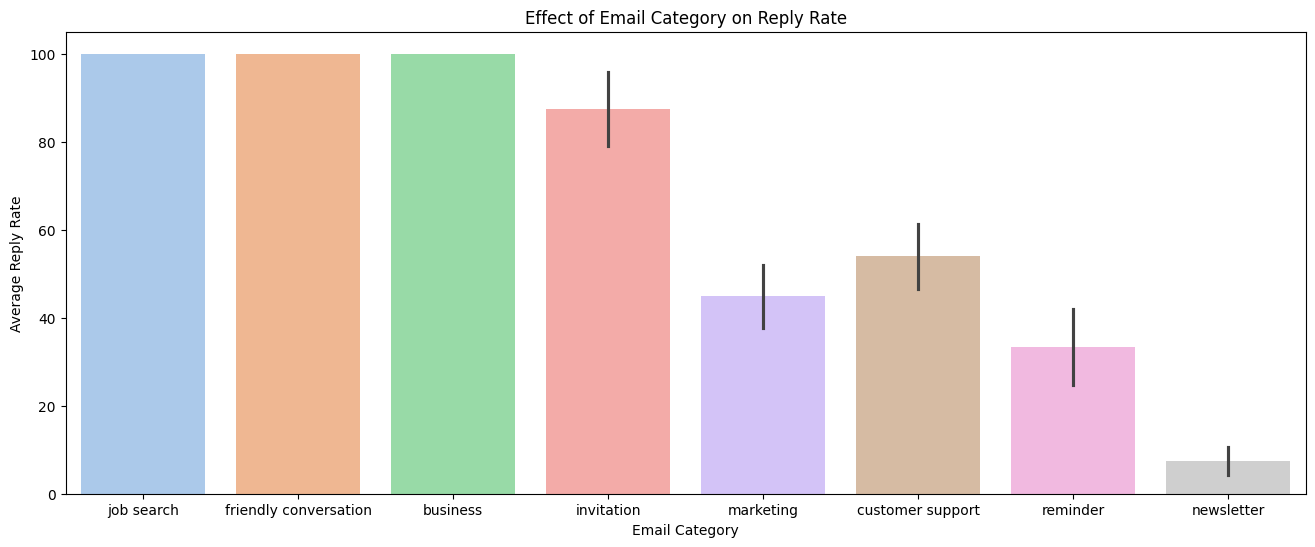

In [48]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="Category", y="Percentage", data=df, palette="pastel", hue="Category", errorbar="sd")

plt.title("Effect of Email Category on Reply Rate")
plt.xlabel("Email Category")
plt.ylabel("Average Reply Rate")
# plt.ylim(0, 100)
plt.show()

# Reply Rate by Domain Name

In [66]:
def calc_domain_reply_rate(target_recipient, messages):
    total_counts = defaultdict(int)
    reply_counts = defaultdict(int)

    for message in messages:

        if target_recipient == message.recipient:
            total_counts[message.sender.split("@")[1]] += 1

        elif target_recipient == message.sender:            
            original = messages[message.original_message]
            reply_counts[original.sender.split("@")[1]] += 1

    domains = total_counts.keys()
    reply_rates = dict()
    for domain in domains:
        reply_rates[domain] = 100 * reply_counts[domain] / total_counts[domain]

    return reply_rates

In [67]:
rounds, all_messages = load_messages("reply_rate_by_domain")
round_reply_rates = []

for round in rounds:
    messages = rounds[round]
    reply_rates = calc_domain_reply_rate("Greene.5@hotmail.co.uk", messages)
    round_reply_rates.append(reply_rates)

data = {
    "Domain": [],
    "Round": [],
    "Percentage": [],
}

for round_num, reply_rates in enumerate(round_reply_rates):
    for domain, rate in reply_rates.items():
        data["Round"].append(round_num)
        data["Domain"].append(domain)
        data["Percentage"].append(rate)

df = pd.DataFrame(data)
df = df.sort_values(by="Percentage", ascending=False)

Loaded 20 rounds with 2520 total messages for table "Reply Rate by Domain"


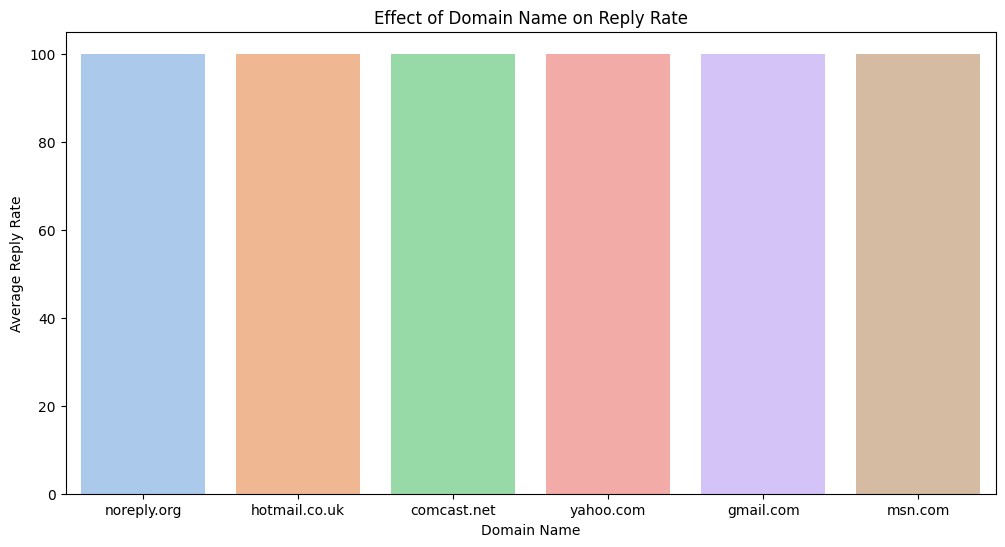

In [69]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Domain", y="Percentage", data=df, palette="pastel", hue="Domain", errorbar="sd")

plt.title("Effect of Domain Name on Reply Rate")
plt.xlabel("Domain Name")
plt.ylabel("Average Reply Rate")
plt.show()